## 5.4 สร้างโมเดลลำดับโดยไลบรารี TF

ในหัวข้อนี้เป็นการศึกษาวิธีการสร้างโมเดล RNN และ LSTM บนกรอบการทำงานของ TF 
โดยใช้ข้อมูลสังเคราะห์ที่อธิบายในภาคผนวก A 

**ตัวอย่าง 5.1**

จากภาคผนวก A เราได้ใช้โมเดล DNN พยากรณ์ข้อมูลอนุกรมเวลาสังเคราะห์ โดยได้สมรรถนะที่ดีในระดับหนึ่ง 
คือค่าผิดพลาด mse=298.72, mae = 13.63 (ค่าอาจแตกต่างกันไปบ้างในการรันแต่ละครั้ง) 
ในตัวอย่างนี้ต้องการสร้างโมเดลโดยใช้ RNN เพื่อพยากรณ์ข้อมูลเดิม 
เพื่อความสะดวกได้นำเอาโค้ดสำหรับสร้างอนุกรมเวลาสังเคราะห์มาใส่ในเซลล์ด้านล่างนี้ 
รวมถึงโค้ดสำหรับแบ่งข้อมูลฝึกและตรวจสอบ และจัดรูปข้อมูลฝึก
(อ่านคำอธิบายได้ในภาคผนวก A)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.9.1'

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None,xlabel="time (days)",ylabel="value"):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(t, slope=0):
    return slope * t

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    -np.cos(season_time * 2.8 * np.pi),
                    -0.1*np.exp(2.3*season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1):
    return np.random.randn(len(time)) * noise_level



In [4]:
baseline = 50
amplitude = 50
slope = 0.04
noise_level=15
sample_time = np.arange(4 * 365 + 1)
sample_series = baseline + trend(sample_time, slope) + seasonality(sample_time, period=365, amplitude=amplitude)+noise(sample_time, noise_level)
#plot_series(sample_time, sample_series)

In [5]:
split_time = 365*3
time_train = sample_time[:split_time]
x_train = sample_series[:split_time]
time_valid = sample_time[split_time:]
x_valid = sample_series[split_time:]

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
train_dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2022-05-31 12:18:58.819934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


สร้างโมเดลลำดับโดยใช้ชั้น SimpleRNN() ซ้อนกัน 2 ชั้น โดยในชั้นแรกจะต้องใช้อาร์กิวเมนต์ 
return_sequence = True ให้ลำดับทั้งหมดออกที่เอาต์พุตของชั้นแรกเพื่อเป็นอินพุตของชั้นที่สอง 
สำหรับชั้นที่สองมีเอาต์พุตเดียว ใช้ชั้น Dense(1) รองรับ ส่วนชั้น Lambda() 
ชั้นบนสุดทำหน้าที่ปรับรูปของอินพุตจากฟังก์ชัน windowed_dataset() ให้สอดคล้องกับโมเดล 
ชั้น Lambda() สุดท้ายทำหน้าที่ปรับมาตราส่วนให้เหมาะสม โค้ดในการสร้างโมเดลเป็นดังนี้ 

In [52]:
rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

คอมไพล์โดยกำหนดอัตราการเรียนรู้ที่เหมาะสม (อาจต้องมีการทดลองปรับหลายครั้ง) และใช้ตัวหาค่าเหมาะที่สุดแบบ Adam
และตั้งค่าสูญเสียเป็นแบบ [Huber](https://en.wikipedia.org/wiki/Huber_loss) ที่มีความไวต่อการรบกวนน้อยกว่าแบบ mse

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)


In [54]:
rnn_model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

ฝึกโมเดลโดยข้อมูลที่จัดรูปแล้วเป็นจำนวน 400 รอบ

In [55]:
rnn_history = rnn_model.fit(train_dataset,epochs=400,verbose=0)

ดูผลการพยากรณ์จากโมเดลได้ดังรูปที่ 5.10

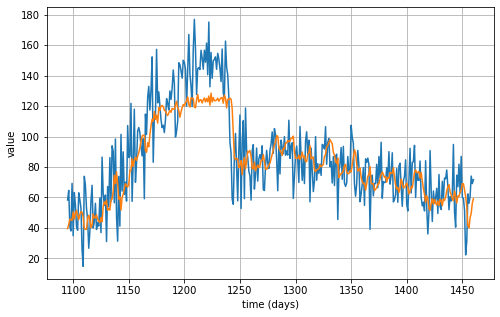

In [49]:
rnn_forecast=[]
for time in range(len(sample_series) - window_size):
    rnn_forecast.append(rnn_model.predict(sample_series[time:time + window_size][np.newaxis],verbose=0))

rnn_forecast = rnn_forecast[split_time-window_size:]
rnn_results = np.array(rnn_forecast)[:, 0, 0]


plt.figure(figsize=(8, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_results)

รูปที่ 5.10 ผลการพยากรณ์จากโมเดล RNN

จากผลการพยากรณ์จะเห็นว่ามีค่าผิดพลาดมากในบริเวณส่วนยอดของข้อมูล
ตรวจสอบค่าตัววัดเปรียบเทียบกับผลจากภาคผนวก A พบว่ามีค่าสูงกว่าเล็กน้อย 

In [56]:
print(keras.metrics.mean_squared_error(x_valid, rnn_results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, rnn_results).numpy())

369.72046
15.365743


**ตัวอย่าง 5.2**

ในตัวอย่างนี้จะใช้ข้อมูลเดิมจากตัวอย่าง 5.1 แต่เปลี่ยนชั้น RNN ในโมเดลเป็นชั้น LSTM สองทิศทาง โค้ดสำหรับสร้างโมเดลเป็นดังนี้

In [57]:
lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


คอมไพล์โดยใช้อาร์กิวเมนต์เหมือนในตัวอย่าง 5.1 และฝึกจำนวนเท่ากัน

In [58]:
lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mae"])

In [59]:
lstm_history = lstm_model.fit(train_dataset,epochs=400,verbose=0)

ดูผลการพยากรณ์จากโมเดลได้ดังรูปที่ 5.11

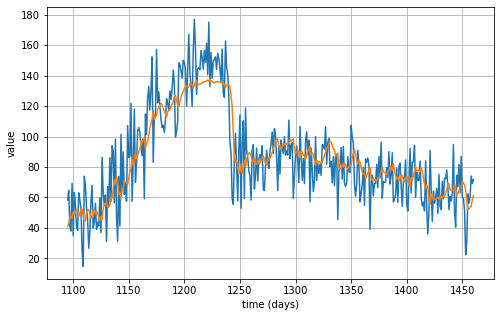

In [42]:
lstm_forecast=[]
for time in range(len(sample_series) - window_size):
    lstm_forecast.append(lstm_model.predict(sample_series[time:time + window_size][np.newaxis],verbose=0))

lstm_forecast = lstm_forecast[split_time-window_size:]
lstm_results = np.array(lstm_forecast)[:, 0, 0]


plt.figure(figsize=(8, 5))

plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_results)

รูปที่ 5.11 ผลการพยากรณ์จากโมเดล LSTM

จากผลการพยากรณ์จะเห็นว่ามีการปรับปรุงขึ้นจากโมเดล RNN ตรวจสอบค่าผิดพลาดพบว่ามีค่าน้อยลง 

In [61]:
print(keras.metrics.mean_squared_error(x_valid, lstm_results).numpy())
print(keras.metrics.mean_absolute_error(x_valid, lstm_results).numpy())

309.9128
13.99026


**ตัวอย่าง 5.3** 

เราสามารถใช้ชั้นสังวัตนาการมิติเดียวมาเป็นชั้นอินพุตของโมเดลก่อนหน้าชั้น RNN หรือ LSTM ได้ โดยต้องมีการแก้ไขฟังก์ชันจัดรูปข้อมูลฝึกเล็กน้อย
ตามโค้ดด้านล่างนี้

In [62]:
def windowed_dataset2(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

นิยามฟังก์ชันช่วยในการพยากรณ์

In [68]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds,verbose=0)
    return forecast

จัดรูปข้อมูลฝึกโดยฟังก์ชันใหม่

In [64]:
window_size = 30
train_dataset2 = windowed_dataset2(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

สร้างโมเดล c1d_lstm_model ที่มีชั้นสังวัตนาการมิติเดียวเป็นอินพุต

In [78]:
c1d_lstm_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

คอมไพล์โดยใช้ตัวเลือกเดิม และฝึกจำนวนเท่าเดิมแต่ใช้ข้อมูลที่จัดรูปใหม่

In [79]:
c1d_lstm_model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer,metrics=["mae"])

In [80]:
c1d_lstm_history = c1d_lstm_model.fit(train_dataset2,epochs=400,verbose=0)

หลังจากการฝึกแล้วเสร็จ พยากรณ์โดยใช้ฟังก์ชันที่นิยามด้านบน รูปที่ 5.12 แสดงผลการพยากรณ์

In [81]:
c1d_lstm_forecast = model_forecast(c1d_lstm_model, sample_series[..., np.newaxis], window_size)
c1d_lstm_forecast = c1d_lstm_forecast[split_time - window_size:-1, -1, 0]

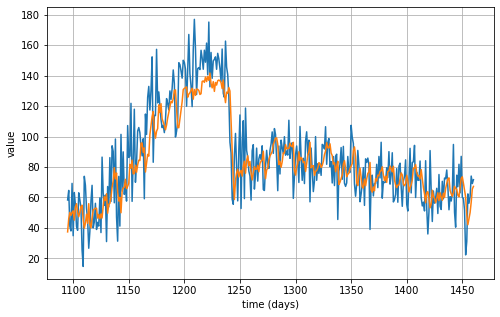

In [82]:
plt.figure(figsize=(8, 5))
plot_series(time_valid, x_valid)
plot_series(time_valid, c1d_lstm_forecast)

รูปที่ 5.12 ผลการพยากรณ์จากโมเดล Conv1D+LSTM

ตรวจสอบค่าผิดพลาด

In [83]:
print(keras.metrics.mean_squared_error(x_valid, c1d_lstm_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, c1d_lstm_forecast).numpy())

324.62024
14.412156


## 5.x สรุปท้ายบท

เนื้อหาในบทนี้กล่าวถึงสถาปัตยกรรมโครงข่ายประสาทเทียมที่ใช้กับข้อมูลลำดับเริ่มจากโมเดลพื้นฐานคือ RNN จนถึงโมเดลขั้นสูงขึ้นคือ GRU, LSTM 
และยกตัวอย่างการสร้างโมเดลบนกรอบการทำงานของ TF 

ถึงแม้ว่า RNN, GRU, LSTM จะสามารถทำงานกับข้อมูลลำดับได้อย่างมีประสิทธิภาพ สถาปัตยกรรมนี้ยังมีข้อด้อยในประเด็นดังนี้

<ol>
<li />การหายไปของเกรเดียนต์สำหรับโมเดลที่มีขั้นลำดับยาวมากยังคงเป็นปัญหา
<li />โมเดลจำเป็นต้องประมวลผลตามลำดับขั้นเวลา จึงไม่สามารถใช้ประโยชน์จากตัวประมวลผลแบบขนานเช่น GPU
<li />การถ่ายโอนการเรียนรู้โดยทั่วไปไม่ประสบผลสำเร็จ โมเดลต้องการการฝึกโดยข้อมูลจำเพาะสำหรับปัญหานั้น
</ol>

โดยเหตุนี้เองปัจจุบันจึงมีการนำเสนอสถาปัตยกรรมทางเลือกสำหรับปัญหาเช่น NLP โดยใช้ทรานส์ฟอร์มเมอร์ส (transformers)
ซึ่งอาศัยกลไกของตัวเข้ารหัส ตัวถอดรหัส และความสนใจ (attention) ข้อแตกต่างหลักคือจะประมวลผลข้อมูลลำดับพร้อมกันทั้งชุด 
ดังนั้นสามารถใช้ประโยชน์จาก GPU ได้ อย่างไรก็ตามจะไม่สามารถใช้กับข้อมูลขั้นเวลาในรูปแบบเรียลไทม์ เช่นอินพุตที่รับโดยหุ่นยนต์ขณะทำงาน
ทรานส์ฟอร์มเมอร์สเป็นเนื้อหาที่อยู่นอกขอบเขตหนังสือนี้

## โจทย์ปัญหา

5-1 จากตัวอย่าง 5.1 - 5.3 ปรับแต่งโมเดลและ/หรือไฮเปอร์พารามิเตอร์เพื่อปรับปรุงค่าผิดพลาดให้น้อยลง โดยตั้งเป้าว่าควรน้อยกว่าค่าที่ได้จากโมเดล DNN 
ในภาคผนวก A 

5-2 ใช้โมเดลจากตัวอย่าง 5.1 - 5.3 พยากรณ์ข้อมูลจุดบอดบนดวงอาทิตย์ (sunspot) ดาวน์โหลดข้อมูลได้จากโค้ดด้านล่าง พล็อตข้อมูลได้ดังแสดงในรูปที่ P5.2

In [84]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2022-05-31 14:29:58--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.1s    

2022-05-31 14:29:58 (498 KB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



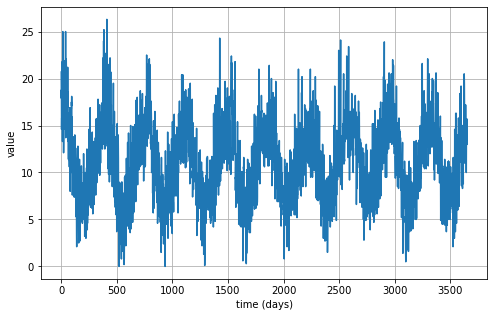

In [85]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(8,5))
plot_series(time, series)

In [ ]:
รูปที่ P5.1 ข้อมูลจุดบอดบนดวงอาทิตย์

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja 2022</div>